# Optimization

# Gradient Descent 

### Read Data

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
data = pd.read_csv('assignment_2.csv')
data.head()

,Label,bias,experience,salary
0,1,1,0.7,48000
1,0,1,1.9,48000
2,1,1,2.5,60000
3,0,1,4.2,63000
4,0,1,6.0,76000


### Split Data

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0], test_size = 0.25, random_state = 0)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((150, 3), (50, 3), (150,), (50,))

### Scaling

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
bias_train = X_train["bias"]
bias_train = bias_train.reset_index()["bias"]
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_train["bias"] = bias_train
X_train.head()

,bias,experience,salary
0,1,0.187893,-1.143335
1,1,1.185555,0.043974
2,1,-0.310938,-0.351795
3,1,-1.629277,-1.341220
4,1,-1.308600,0.043974


In [7]:
bias_test = X_test["bias"]
bias_test = bias_test.reset_index()["bias"]
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
X_test["bias"] = bias_test
X_test.head()

,bias,experience,salary
0,1,-1.344231,-0.615642
1,1,0.508570,0.307821
2,1,-0.310938,0.571667
3,1,1.363709,1.956862
4,1,-0.987923,-0.747565


In [8]:
# parameter 개수
N = len(X_train.loc[0])

In [9]:
# 초기 parameter들을 임의로 설정해줍니다.
parameters = np.array([random.random() for i in range(N)])
random_parameters = parameters.copy()
parameters

array([0.624026  , 0.03586074, 0.62110758])

In [12]:
X_train

,bias,experience,salary
0,1,0.187893,-1.143335
1,1,1.185555,0.043974
2,1,-0.310938,-0.351795
3,1,-1.629277,-1.341220
4,1,-1.308600,0.043974
...,...,...,...
145,1,0.686724,-0.087949
146,1,0.009739,0.505706
147,1,0.793616,1.363207
148,1,1.007401,0.835514


In [11]:
X_train.shape, parameters.shape

((150, 3), (3,))

## Dot product
## $z = X_i \theta$

In [11]:
def dot_product(X, parameters):
    z = 0
    for i in range(len(parameters)):
        z += X[i] * parameters[i]
    return z

< X와 그에 대응하는 parameter값의 내적을 구현하는 함수이다. 반복문을 통해 1부터 i번째까지의 X와 parameter값을 곱해서 더해준값을 return 해준다. > 

## Logistic Function

## $p = \frac{1}{1 + e^{-z}}$

- 선형 회귀 분석이란 독립변수들이 변화해 갈 때 종속 변수가 어떻게 변화하는지 알아보는것이 목적.
- 2가지의 결과 (참,거짓)으로 종속변수(y)를 갖기위한 함수 식

In [12]:
import math

In [13]:
def logistic(X, parameters):
    z = dot_product(X,parameters)
    p = 1 / (1 + np.exp(-z)) 
    return p

In [14]:
logistic(X_train.iloc[1], parameters)

0.7646995006417049

**< 로지스틱 함수 또는 시그모이드 함수라고 불리우며 항상 0과 1사이에 값을 가집니다. >**

## Object function

Object Function : 목적함수는 Gradient Descent를 통해 최적화 하고자 하는 함수입니다.  
<br>
선형 회귀의 목적함수
## $l(\theta) = \frac{1}{2}\Sigma(y_i - \theta^{T}X_i)^2$  
참고) $\hat{y_i} = \theta^{T}X_i$
  
로지스틱 회귀의 목적함수를 작성해주세요  
(선형 회귀의 목적함수처럼 강의에 나온대로 작성해주세요. 평균을 고려하는 것은 뒤에 코드에서 수행합니다)
## $l(p) = -\frac{1}{2}\Sigma[y_i\log(\theta^{T}X_i)+(1-y_i)\log(1-\theta^{T}X_i)]$

In [15]:
def minus_log_cross_entropy_i(X, y, parameters):
    p = logistic(X, parameters)
    loss = (y*np.log(p) + (1-y)*np.log(1-p))
    return -loss

**< cross entropy함수는 로지스틱 회귀의 목적함수 또는 손실함수입니다. 손실함수란 모델이 나타내는 확률 분포 ( 예측값 ) 와 실제 확률 분포 ( 실제값 )의 차이를 나타내는 함수입니다. Cross-entropy 함수는 실제값(y)에 일어날 확률(p)를 log변환 해준것의 곱과 예측값(y-hat, 여기서는 이중분류라서 1-y를 사용)과 일어날 확률 (q)를 log변환해준것의 곱을 더하여 음수로 만든것이다. >**

In [16]:
def mse_i(X, y, parameters):
    y_hat = dot_product(X, parameters.T)
    loss = ((y - y_hat)**2) / 2
    return loss

**< MSE란, Mean Squared Error로 실제값(y)에서 예측값(y-hat)을 빼준 값을 제곱한 다음 표본의 개수만큼 나눈것이다 >**

In [17]:
def batch_loss(X_set, y_set, parameters, loss_function, n): #n:현재 배치의 데이터 수
    loss = 0
    for i in range(X_set.shape[0]):
        X = X_set.iloc[i,:]
        y = y_set.iloc[i]
        loss += loss_function(X,y, parameters)
    loss = loss / n
    return loss

In [18]:
batch_loss(X_test, y_test, parameters, minus_log_cross_entropy_i, len(X_test))

1.1368803624228452

**< Data의 손실을 구하고 Data의 batch의 수 만큼 나누어 loss의 평균을 구해주는 함수다(?)  >**

## Gradient
위의 선형회귀의 목적함수 $l(\theta)$와 로지스틱회귀의 목적함수 $l(p)$의 gradient를 작성해주세요  
(위의 목적함수를 참고해서 작성해주세요 = 평균을 고려하는 것은 뒤에 코드에서 수행합니다)

## ${\partial\over{\partial \theta_j}}l(\theta)= -\Sigma(y_i - \theta^{T}X_i)X_{ij}$ 
## ${\partial\over{\partial \theta_j}}l(p)= -\Sigma(y_i - p_i)X_{ij}$ 

In [19]:
def get_gradient_ij(X, y, parameters, j, model):
    if model == 'linear':
        y_hat = dot_product(X, parameters.T)
        gradient = (y-y_hat) * X[j]
    else:
        p = logistic(X, parameters)
        gradient = (y-p) * X[j]
    return -gradient

In [20]:
get_gradient_ij(X_train.iloc[0,:], y_train.iloc[0], parameters, 1, 'linear')

-0.14826851856802198

In [21]:
get_gradient_ij(X_train.iloc[0,:], y_train.iloc[0], parameters, 1, 'logistic')

-0.08407694111542571

**< 위 함수는 model이 선형일때와 로지스틱일때를 구분하여 gradient를 구하는 함수이다. 먼저 선형일 때 gradient는 예측값(y_hat)을 X와 parameter를 transpose한 값을 dot_product해주어 구하고 실제값인 y에서 y_hat을 빼준 뒤 X의 j번째의 값과 곱해준것이다.
model이 로지스틱일때 기울기(gradient)는 실제값(y)에서 로지스틱함수(p)를 빼주고 X의 j번째와 곱한값이다.  >**

## Batch Gradient
하나의 배치 (X_set, y_set)에 대해 기울기를 구하는 코드를 작성해주세요

In [17]:
y_train.iloc[0] 

1

In [22]:
def batch_gradient(X_set, y_set, parameters, model):
    gradients = [0 for _ in range(len(parameters))]
    
    for i in range(len(X_set)):
        X = X_set.iloc[i,:]
        y = y_set.iloc[i]
        for j in range(len(parameters)):
            gradients[j] += get_gradient_ij(X, y, parameters, j, model)
    
    return gradients

In [23]:
gradients2 = batch_gradient(X_train, y_train, parameters, 'linear')
gradients2

[52.15389821061275, 97.983568384196, 129.72120573873747]

In [24]:
gradients1 = batch_gradient(X_train, y_train, parameters, 'logistic')
gradients1

[52.662079106152795, 5.817436762204624, 37.46871865544021]

**< 위에 정의된 함수는 batch 하나의 gradient를 구해주는 함수이다. >**

## mini-batch
인덱스로 미니 배치 나누기

In [25]:
def batch_idx(X_train, batch_size):
    N = len(X_train)
    nb = (N // batch_size)+1 #number of batch
    idx = np.array([i for i in range(N)])
    idx_list = [idx[i*batch_size:(i+1)*batch_size] for i in range(nb) if len(idx[i*batch_size:(i+1)*batch_size]) != 0]
    return idx_list

batch_idx 함수에 대한 설명을 batch_size와 함께 간략하게 작성해주세요  
#### 설명: < index를 활용하여 batch를 부분집합으로 나누는 함수이다. X_train의 크기가 200이고 batch_size가 20이라고 가정할 때 mini batch의 사이즈는 20으로 10개로 나누어진다. batch_size가 커지면 한번 학습할 때 데이터의 크기가 커지고 mini-batch의 개수가 적어지게 되고 batch_size가 작아지면 한번 학습할 때 데이터의 크기는 작아지지만 mini-batch의 개수는 많아진다. >

## Update Parameters
기울기를 갱신하는 코드를 작성해주세요  
(loss와 마찬가지로 기울기를 갱신할 때 배치 사이즈를 고려해 평균으로 갱신해주세요)

In [26]:
def step(parameters, gradients, learning_rate, n): #n:현재 배치의 데이터 수
    for i in range(len(parameters)):
        gradients[i] *= learning_rate * (1/n)
    
    parameters -= gradients
    return parameters

In [27]:
step(parameters, gradients1, 0.01, len(X_train))

array([0.62418185, 0.44805624, 0.43574939])

**< gradient descent의 공식을 보면 alpha(learning_rate)와 n(batch_size)과 gradient((y-p) * X[j])를 곱해준다. learning rate가 클수록 gradient 그래프에서 한번에 많이 움직이게 되고 편미분항이 이동할 방향과 크기를 결정하게된다. >**

## Gradient Descent
위에서 작성한 함수들을 조합해서 경사하강법 함수를 완성해주세요

- learning_rate: 학습률  
- tolerance: Step이 너무 작아서 더 이상의 학습이 무의미할 때 학습을 멈추는 조건  
- batch: 기울기를 1번 갱신할 때 사용하는 데이터셋  
- epoch: 한번 학습을 완료한 상태의 횟수
- num_epoch: 총 횟수
<br

BGD: "배치 경사 하강법 - 매 step에서 train data 전체를 대상으로 gradient의 평균을 구하여 최적의 해를 찾는 기법"

SGD: "loss function을 계산할 때, 일부 데이터의 모음(Mini-Batch)를 사용하여 loss function을 계산하는 기법, 다소 정확도는 BGD에 비해 낮을수도 있지만 계산 속도가 훨씬 빨
 서 더 많은 step을 나아갈 수 있고 local minima에 빠질 가능성이 적다."

MGD: "전체 train data를 batch_size로 등분하여 batch set을 순차적으로 수행, BGD보다 빠르고 SGD보다 낮은 오차율을 보여준다."
<br

batch_size에 따른 경사하강법의 종류를 적어주세요

batch_size=1 -> "SGD" * (SGD는 하나의 batch를 보고 gradient를 바로 계산하여 적용한다)

batch_size=k -> "MGD"

batch_size=whole -> "BGD"  

In [28]:
def gradient_descent(X_train, y_train, model, learning_rate = 0.1, num_epoch = 1000, tolerance = 0.00001, batch_size = 16):
    stopper = False
    
    N = len(X_train.iloc[0])
    parameters = np.random.rand(N)
    loss_function = minus_log_cross_entropy_i if model == 'logistic' else mse_i
    loss = 999
    batch_idx_list = batch_idx(X_train, batch_size)
    
    for epoch in range(num_epoch):
        if stopper:
            break
        for idx in batch_idx_list:
            X_batch = X_train.iloc[idx,]
            y_batch = y_train.iloc[idx]
            gradients = batch_gradient(X_batch, y_batch, parameters, model)
            parameters = step(parameters, gradients, learning_rate, batch_size)
            new_loss = batch_loss(X_batch, y_batch, parameters, loss_function, batch_size)
            
            #중단 조건
            if abs(new_loss - loss) < tolerance:
                stopper = True
                break
            loss = new_loss
        
        #100epoch마다 학습 상태 출력
        if epoch%100 == 0: #출력이 길게 나오면 check point를 수정해도 됩니다.
            print(f"epoch: {epoch}  loss: {new_loss}  params: {parameters}  gradients: {gradients}")
    
    return parameters

## Implement
경사하강법 함수를 이용해 최적의 모수 찾아보세요. 학습을 진행할 때, Hyper Parameter를 바꿔가면서 학습시켜보세요.

## Logistic Regression

In [29]:
new_param_bgd = gradient_descent(X_train, y_train, learning_rate = 0.1, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = X_train.shape[0])
new_param_bgd

epoch: 0  loss: 0.9407442704541807  params: [0.36424034 0.16457728 0.80028429]  gradients: [0.02985160067971767, 0.004157745195278829, 0.028821510596084857]
epoch: 100  loss: 0.47961606233886445  params: [-0.81745526  0.68216404 -0.59567898]  gradients: [0.003463701844948239, -0.007050985502951244, 0.007528620361523285]
epoch: 200  loss: 0.40408127515386  params: [-1.01451293  1.27354563 -1.19175426]  gradients: [0.0012564161659728522, -0.0049204829347018406, 0.004837862045726561]
epoch: 300  loss: 0.368158205516972  params: [-1.11879682  1.69417298 -1.60295184]  gradients: [0.0009031414214740496, -0.0036192516492136863, 0.0035208665160749494]
epoch: 400  loss: 0.34771868379988924  params: [-1.20057916  2.01277551 -1.91179677]  gradients: [0.0007454583643815325, -0.0028191927037198214, 0.0027233202959414653]
epoch: 500  loss: 0.3348479721259819  params: [-1.26913098  2.26604984 -2.1557589 ]  gradients: [0.000631498232509359, -0.002284135963908753, 0.002193962166473218]
epoch: 600  loss

array([-1.49382871,  3.0428233 , -2.89533021])

In [30]:
new_param_bgd2 = gradient_descent(X_train, y_train, learning_rate = 0.5, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = X_train.shape[0])
new_param_bgd2

epoch: 0  loss: 0.9227137430300998  params: [0.32062099 0.76764838 0.620417  ]  gradients: [0.1462672594257117, 0.0691410957356273, 0.17055752897257437]
epoch: 100  loss: 0.33141184902629967  params: [-1.29073547  2.34404167 -2.23061358]  gradients: [0.003012097978809764, -0.010756877226719213, 0.010314830175947209]
epoch: 200  loss: 0.30881321249216026  params: [-1.50568895  3.08253554 -2.93279537]  gradients: [0.0015428436233057272, -0.005159241392792489, 0.004865096837933593]
epoch: 300  loss: 0.30251687825574636  params: [-1.62496899  3.4779381  -3.30400692]  gradients: [0.0009228300542421634, -0.0030370495611848633, 0.0028390287386713836]
epoch: 400  loss: 0.3001554295396636  params: [-1.69924488  3.72151313 -3.53110243]  gradients: [0.0005965347409430432, -0.0019499787983228395, 0.0018134176453566736]


array([-1.72570691,  3.80792238, -3.61138655])

In [31]:
new_param_sgd = gradient_descent(X_train, y_train, learning_rate = 0.1, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = 1)
new_param_sgd

epoch: 0  loss: 0.2665249981539225  params: [-0.90727116  1.23280668 -1.34977627]  gradients: [0.02418152932985493, 0.01315961139016817, 0.01701390015879907]
epoch: 100  loss: 0.07736664557061775  params: [-1.9303264   4.17502159 -4.06769304]  gradients: [0.0075385368602801, 0.004102478969734366, 0.005304044741532554]
epoch: 200  loss: 0.07736266551585466  params: [-1.9303681   4.1751431  -4.06780374]  gradients: [0.0075381595212657805, 0.004102273621481862, 0.005303779249295563]
epoch: 300  loss: 0.0773626651836168  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489767101, 0.00410227360434025, 0.005303779227133383]
epoch: 400  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489764571, 0.004102273604338872, 0.005303779227131603]
epoch: 500  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489764571, 0.004102273604338872, 0.005303779227131603]
epoch: 600  loss: 0.07736

array([-1.9303681 ,  4.17514311, -4.06780375])

In [32]:
new_param_sgd2 = gradient_descent(X_train, y_train, learning_rate = 0.5, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = 1)
new_param_sgd2

epoch: 0  loss: 0.1013456312190334  params: [-1.29682021  2.37345296 -3.17362468]  gradients: [0.05243761263299083, 0.028536598949776695, 0.036894618770120576]
epoch: 100  loss: 0.04527745616703725  params: [-2.10636691  4.22380215 -4.6397031 ]  gradients: [0.023022802186761605, 0.01252903097061125, 0.016198630468658323]
epoch: 200  loss: 0.04527745616703725  params: [-2.10636691  4.22380215 -4.6397031 ]  gradients: [0.023022802186761605, 0.01252903097061125, 0.016198630468658323]
epoch: 300  loss: 0.04527745616703725  params: [-2.10636691  4.22380215 -4.6397031 ]  gradients: [0.023022802186761605, 0.01252903097061125, 0.016198630468658323]
epoch: 400  loss: 0.04527745616703725  params: [-2.10636691  4.22380215 -4.6397031 ]  gradients: [0.023022802186761605, 0.01252903097061125, 0.016198630468658323]
epoch: 500  loss: 0.04527745616703725  params: [-2.10636691  4.22380215 -4.6397031 ]  gradients: [0.023022802186761605, 0.01252903097061125, 0.016198630468658323]
epoch: 600  loss: 0.04527

array([-2.10636691,  4.22380215, -4.6397031 ])

In [33]:
new_param_mgd = gradient_descent(X_train, y_train, learning_rate = 0.5, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = 100)
new_param_mgd

epoch: 0  loss: 0.46326514213928616  params: [0.50525509 0.16929855 0.60479829]  gradients: [0.07076640800730387, 0.009114722677107917, 0.07087610866896263]
epoch: 100  loss: 0.17541671992888871  params: [-1.40293996  2.74294502 -2.61528865]  gradients: [-0.005785440459194763, 0.0007154887462567028, 0.01099147375780448]
epoch: 200  loss: 0.16750022298661776  params: [-1.61852252  3.46170493 -3.29284231]  gradients: [-0.004299438655209298, 0.0031274073189200497, 0.008367872127761456]
epoch: 300  loss: 0.1657763296262523  params: [-1.72223543  3.80052994 -3.60858218]  gradients: [-0.0036567896648431963, 0.004013073414219187, 0.007456868552214768]
epoch: 400  loss: 0.16526226516100945  params: [-1.77917296  3.9854013  -3.7799242 ]  gradients: [-0.003322969122525738, 0.004442871862654655, 0.007026071614923202]
epoch: 500  loss: 0.16508687332307054  params: [-1.81233122  4.09275762 -3.87913255]  gradients: [-0.0031347139518594427, 0.0046770342351734745, 0.006794592978445153]
epoch: 600  los

array([-1.85946666,  4.24502253, -4.01948441])

In [34]:
new_param_mgd2 = gradient_descent(X_train, y_train, learning_rate = 0.5, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = 50)
new_param_mgd2

epoch: 0  loss: 0.648239646588072  params: [-0.19426456  0.63376576 -0.01644145]  gradients: [0.06741034821212942, 0.02583640486468207, 0.12497356158372182]
epoch: 100  loss: 0.3343129464776427  params: [-1.62773889  3.49088986 -3.33002791]  gradients: [-0.008723586216737545, 0.0064776510353849485, 0.016697025094877065]
epoch: 200  loss: 0.33026165259188534  params: [-1.78256557  3.99297034 -3.79627067]  gradients: [-0.00680404792883913, 0.009002787570273556, 0.01415509421229803]
epoch: 300  loss: 0.3298274726010855  params: [-1.83400773  4.1586803  -3.94915561]  gradients: [-0.006212604487433361, 0.009719304716277338, 0.013453975794865534]
epoch: 400  loss: 0.329766282655861  params: [-1.85310489  4.22008435 -4.00568662]  gradients: [-0.005998799579097311, 0.009971948776147073, 0.01320897871096581]
epoch: 500  loss: 0.32975648703554056  params: [-1.8604539   4.24369859 -4.02740971]  gradients: [-0.005917346662676183, 0.01006733805666431, 0.013116780186137687]
epoch: 600  loss: 0.32975

array([-1.86512466,  4.25870258, -4.0412072 ])

**< loss값은 SGD기법과 learning_rate를 올린것이 제일 작았다. >**

### Predict Label

In [35]:
### BGD를 이용해 얻은 parameter로 예측 
y_predict_bgd = []
y_predict_proba_bgd = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], new_param_bgd)
    y_predict_proba_bgd.append(p)
    if p > 0.5:
        y_predict_bgd.append(1)
    else:
        y_predict_bgd.append(0)

### SGD를 이용해 얻은 parameter로 예측         
y_predict_sgd = []
y_predict_proba_sgd = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], new_param_sgd)
    y_predict_proba_sgd.append(p)
    if p > 0.5:
        y_predict_sgd.append(1)
    else:
        y_predict_sgd.append(0)

### MGD를 이용해 얻은 parameter로 예측 
y_predict_mgd = []
y_predict_proba_mgd = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], new_param_mgd)
    y_predict_proba_mgd.append(p)
    if p > 0.5:
        y_predict_mgd.append(1)
    else:
        y_predict_mgd.append(0)


### random_parameter로 예측         
y_predict_random = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], random_parameters)
    if p> 0.5 :
        y_predict_random.append(1)
    else :
        y_predict_random.append(0)

### Confusion Matrix

In [36]:
from sklearn.metrics import *

def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print('confusion matrix')
    print(confusion)
    print('precision : {0:.4f}, accuracy : {1:.4f}, recall : {2:.4f}'.format(precision, accuracy, recall))

In [37]:
get_clf_eval(y_test, y_predict_bgd)

confusion matrix
[[38  2]
 [ 4  6]]
precision : 0.7500, accuracy : 0.8800, recall : 0.6000


In [38]:
get_clf_eval(y_test, y_predict_sgd)

confusion matrix
[[38  2]
 [ 1  9]]
precision : 0.8182, accuracy : 0.9400, recall : 0.9000


In [39]:
get_clf_eval(y_test, y_predict_mgd)

confusion matrix
[[38  2]
 [ 1  9]]
precision : 0.8182, accuracy : 0.9400, recall : 0.9000


In [40]:
get_clf_eval(y_test, y_predict_random)

confusion matrix
[[ 8 32]
 [ 1  9]]
precision : 0.2195, accuracy : 0.3400, recall : 0.9000


In [41]:
def roc_auc(y, predict_proba):
    score = roc_auc_score(y, predict_proba)
    return print('ROC_AUC : {0:.4f}'.format(score))

In [42]:
roc_auc(y_test, y_predict_proba_bgd)

ROC_AUC : 0.9525


In [43]:
roc_auc(y_test, y_predict_proba_mgd)

ROC_AUC : 0.9525


In [44]:
roc_auc(y_test, y_predict_proba_sgd)

ROC_AUC : 0.9500


In [45]:
def f1score(y_test, y_pred):
    return print('F1-score : {0:.4f}'.format(f1_score(y_test,y_pred)))

In [46]:
f1score(y_test, y_predict_bgd)

F1-score : 0.6667


In [47]:
f1score(y_test, y_predict_sgd)

F1-score : 0.8571


In [48]:
f1score(y_test, y_predict_mgd)

F1-score : 0.8571


In [49]:
f1score(y_test, y_predict_random)

F1-score : 0.3529


**< MGD와 SGD와 왜 같게 나오는지는 정확히 모르지만 점수가 다 똑같이 나왔고 BGD는 SGD와 MGD보다 점수가 낮게 나왔다. 그리고 roc_auc의 점수가 제일 높게 나왔다. >**

## Linear regression
### $y = 0.5 + 2.7x$

### Data

In [41]:
raw_X = np.random.rand(150)
y = 2.7*raw_X + 0.5 + np.random.randn(150)

In [42]:
tmp = np.array([1 for _ in range(150)])
X = np.vstack((tmp, raw_X)).T
X = pd.DataFrame(X)
y = pd.Series(y)

### Estimation

In [43]:
#정규방정식
theta = np.linalg.inv(np.dot(X.T,X)).dot(X.T).dot(y)
theta

array([0.44428813, 2.8805832 ])

In [44]:
#경사하강법
new_param = gradient_descent(X,y, model = 'linear')
new_param

epoch: 0  loss: 0.48868168402311923  params: [0.88144598 1.2514324 ]  gradients: [0.0064784734374964265, 0.0037493006474613403]
epoch: 100  loss: 0.6352784432214742  params: [0.40176683 2.85319931]  gradients: [0.030743372000371208, 0.026644547895773415]
epoch: 200  loss: 0.63553822731808  params: [0.40018664 2.8560316 ]  gradients: [0.030757235003213364, 0.026665245440741406]
epoch: 300  loss: 0.6355387426513447  params: [0.4001835  2.85603722]  gradients: [0.030757262484082837, 0.02666528646984155]
epoch: 400  loss: 0.6355387436729005  params: [0.4001835  2.85603723]  gradients: [0.030757262538558677, 0.026665286551174283]
epoch: 500  loss: 0.6355387436749254  params: [0.4001835  2.85603723]  gradients: [0.030757262538666664, 0.0266652865513355]
epoch: 600  loss: 0.6355387436749294  params: [0.4001835  2.85603723]  gradients: [0.030757262538666865, 0.026665286551335807]
epoch: 700  loss: 0.6355387436749294  params: [0.4001835  2.85603723]  gradients: [0.030757262538666865, 0.02666528

array([0.4001835 , 2.85603723])

In [45]:
y_hat_NE = theta.dot(X.T)
y_hat_GD = new_param.dot(X.T)

### Visualization
시각화를 통해 정규방정식과 경사하강법을 통한 선형회귀를 비교해보세요  
(밑의 코드를 실행만 시키면 됩니다. 추가 코드 x)

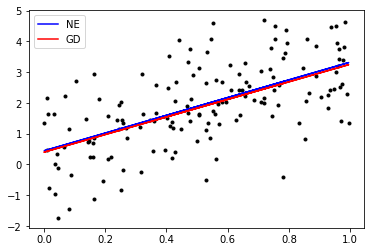

In [46]:
import matplotlib.pyplot as plt
plt.plot(X.iloc[:,1], y, '.k') #산점도
plt.plot(X.iloc[:,1], y_hat_NE, '-b', label = 'NE') #정규방정식
plt.plot(X.iloc[:,1], y_hat_GD, '-r', label = 'GD') #경사하강법
plt.legend()
plt.show()

**< 선에 가깝게 분포되고 있다. >**